In [17]:
from keras_segmentation.models.segnet import vgg_segnet
import numpy as np
import tempfile

import sys 

import keras

from keras_segmentation.models import all_models
from keras_segmentation.data_utils.data_loader import \
    verify_segmentation_dataset, image_segmentation_generator
from keras_segmentation.predict import predict_multiple, predict, evaluate


from keras_segmentation.model_compression import perform_distilation
from keras_segmentation.pretrained import pspnet_50_ADE_20K  

import matplotlib.pyplot as plt

import tensorflow as tf
import datetime

train_images =  "training_set/train_img/"
train_annotations = "training_set/train_ana/"
val_images="training_set/val_img/"
val_annotations="training_set/val_ana/"

In [2]:
model = vgg_segnet(n_classes=7, input_height=416, input_width=608  )

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-19 18:48:30.198469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-19 18:48:30.198758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.train(
    train_images =  "training_set/train_img/",
    train_annotations = "training_set/train_ana/",
    validate=True,
    val_images="training_set/val_img/",
    val_annotations="training_set/val_ana/",
    checkpoints_path = "./check/vgg_segnet_1" , epochs=5,
    steps_per_epoch=64,
    val_steps_per_epoch=64,
    do_augment=True,
    callbacks=[tensorboard_callback]
)

Verifying training dataset


100%|██████████| 185/185 [00:07<00:00, 23.90it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 75/75 [00:03<00:00, 24.11it/s]


Dataset verified! 
Epoch 1/5


2022-06-19 21:27:17.649103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9725

2022-06-19 21:27:51.223249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 42s 632ms/step - loss: 0.1134 - accuracy: 0.9725 - val_loss: 0.1771 - val_accuracy: 0.9522
Epoch 2/5
64/64 [==============================] - 42s 653ms/step - loss: 0.1022 - accuracy: 0.9722 - val_loss: 0.3103 - val_accuracy: 0.9056
Epoch 3/5
64/64 [==============================] - 42s 662ms/step - loss: 0.0986 - accuracy: 0.9733 - val_loss: 0.7165 - val_accuracy: 0.7977
Epoch 4/5
64/64 [==============================] - 42s 662ms/step - loss: 0.0838 - accuracy: 0.9762 - val_loss: 0.0749 - val_accuracy: 0.9780
Epoch 5/5
64/64 [==============================] - 44s 686ms/step - loss: 0.0888 - accuracy: 0.9754 - val_loss: 0.4652 - val_accuracy: 0.8340


In [22]:
predict_multiple(
        inp_dir='training_set/val_img/', checkpoints_path='./check/vgg_segnet_1', out_dir="output_dir")

loaded weights  ./check/vgg_segnet_1.00002


100%|██████████| 75/75 [00:09<00:00,  7.71it/s]


[array([[4, 1, 0, ..., 0, 0, 3],
        [2, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[4, 1, 0, ..., 0, 0, 3],
        [2, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[4, 1, 0, ..., 0, 0, 3],
        [2, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[4, 0, 0, ..., 0, 0, 3],
        [6, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]),
 array([[4, 0, 0, ..., 0, 0, 3],
        [6, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [23]:
ev = model.evaluate_segmentation(inp_images_dir=val_images, annotations_dir=val_annotations)
assert ev['frequency_weighted_IU'] > 0.01
print(ev)

0it [00:00, ?it/s]2022-06-19 21:32:47.592497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
75it [00:10,  7.30it/s]

{'frequency_weighted_IU': 0.8107278036836283, 'mean_IU': 0.13911474013433792, 'class_wise_IU': array([0.8325284 , 0.14127478, 0.        , 0.        , 0.        ,
       0.        , 0.        ])}


In [24]:
out = predict(inp="test.png", checkpoints_path='./check/vgg_segnet_1',
                overlay_img=True, class_names=['1', '2', '3', '4', '5', '6', '7'], show_legends=True)

loaded weights  ./check/vgg_segnet_1.00002


2022-06-19 21:33:23.934793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


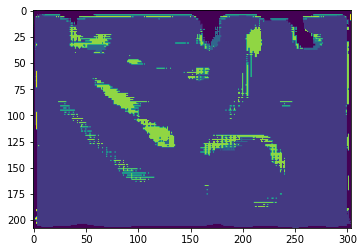

In [25]:
plt.imshow(out)

In [16]:
out.shape

(208, 304)

In [20]:
# %tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.
